In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
from config import settings
from src.data import datamodule as dm
from pathlib import Path
from src.model.transformation import (FromBuffer , 
                                      CutPSD, LogTransform , NormLayer , SqueezeLayer,
                                      UnsqueezeLayer)


import matplotlib.pyplot as plt
from torch import nn 
from src.data.utils import print_database_overview, load_all_from_db 


In [4]:
db_path = Path(settings.path.processed, 'norther3.db')
assert db_path.exists(), f"Database not found at {db_path}"
print_database_overview(db_path)
meta_data = load_all_from_db(db_path, 'metadata')
frequency_axis = FromBuffer()(meta_data.loc[0,'frequency_axis'])

SQLite Database Overview
Table: processed_data - id, timestamp, turbine_name, Welch_X, Welch_Y, Welch_Z, RMS_X, RMS_Y, RMS_Z, RollingAverage_X, RollingAverage_Y, RollingAverage_Z, Range_X, Range_Y, Range_Z, Mean_X, Mean_Y, Mean_Z
Table: sqlite_sequence - name, seq
Table: metadata - frequency_axis, sample_rate, window_size, processing_method
Table: scada - timestamp, mean_windspeed, min_windspeed, max_windspeed, std_windspeed, mean_yaw, min_yaw, max_yaw, std_yaw, mean_power, min_power, max_power, std_power, mean_pitch, min_pitch, max_pitch, std_pitch, mean_rpm, min_rpm, max_rpm, std_rpm, mean_winddirection, min_winddirection, max_winddirection, std_winddirection, mean_NAC_ACC_Z, min_NAC_ACC_Z, max_NAC_ACC_Z, rms_NAC_ACC_Z, rms1p_NAC_ACC_Z, mean_NAC_ACC_FA, min_NAC_ACC_FA, max_NAC_ACC_FA, rms_NAC_ACC_FA, rms1p_NAC_ACC_FA, mean_NAC_ACC_SS, min_NAC_ACC_SS, max_NAC_ACC_SS, rms_NAC_ACC_SS, rms1p_NAC_ACC_SS, mean_ti, pred_Mtn_legacy, relative_wind_dir, pred_Mtn_dnn, Mean_muY, CoV, std_NAC_ACC

/tmp/ipykernel_1269149/1054908431.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  merged_data_C01.query('timestamp > "2023-06-01" and timestamp < "2023-08-10"', inplace=True)


<Axes: xlabel='timestamp'>

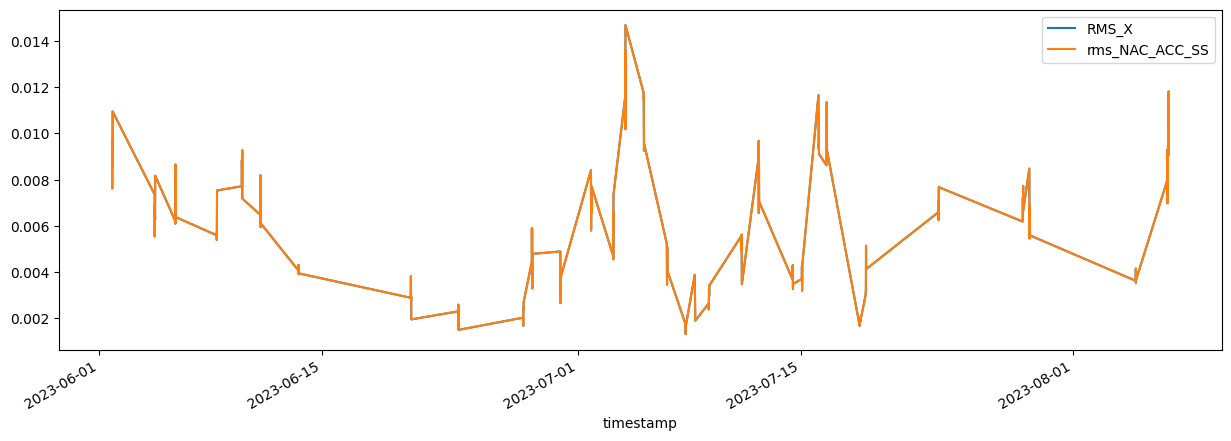

In [5]:
import sqlite3
import pandas as pd

# Connect to the SQLite database
conn = sqlite3.connect(db_path)

# SQL query to merge the required columns from processed_data and scada
query = """
SELECT 
    p.timestamp, 
    p.turbine_name, 
    p.RMS_X, 
    s.rms_NAC_ACC_SS
FROM 
    processed_data p
LEFT JOIN 
    scada s
ON 
    p.timestamp = s.timestamp 
    AND p.turbine_name = s.turbine_name
WHERE 
    p.RMS_X IS NOT NULL 
    AND s.rms_NAC_ACC_SS IS NOT NULL;
"""

# Execute the query and load the result into a pandas DataFrame
merged_data = pd.read_sql_query(query, conn)
merged_data['timestamp'] = pd.to_datetime(merged_data['timestamp']).dt.tz_localize(None)
merged_data_C01 = merged_data[merged_data['turbine_name'] == 'NRTC01']
merged_data_C01.query('timestamp > "2023-06-01" and timestamp < "2023-08-10"', inplace=True)
merged_data_C01.plot(x='timestamp', y=['RMS_X', 'rms_NAC_ACC_SS'], figsize=(15, 5))


# synchronization check == > yes

In [6]:
from src.data.utils import get_statistic
from src.utils.rich_utils import print_stats_as_table

import numpy as np
statistics = get_statistic(db_path,['Welch_X', 'Welch_Y', 'Welch_Z', 'RollingAverage_X', 'RollingAverage_Y', 'RollingAverage_Z'],
              [np.max,np.min,np.std,np.mean], 'processed_data',
              timestamp_range=('2023-01-01', '2024-01-01'))
# let's apply a log transformation to the statistics that contain 'Welch' 
for key,item in statistics.items():
    if 'Welch' in key:
        for stat,values in item.items():
            item[stat] = np.log(values)
print_stats_as_table(statistics)



                Statistics Table                 
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┓
┃ Column Name      ┃ Statistic ┃          Value ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━┩
│ Welch_X          │ max       │       6.603327 │
│ Welch_X          │ min       │     -17.611923 │
│ Welch_X          │ std       │     0.86432964 │
│ Welch_X          │ mean      │     -2.4800177 │
│ Welch_Y          │ max       │       7.549939 │
│ Welch_Y          │ min       │     -18.384657 │
│ Welch_Y          │ std       │     0.34529474 │
│ Welch_Y          │ mean      │     -2.4430842 │
│ Welch_Z          │ max       │      2.2734365 │
│ Welch_Z          │ min       │     -17.452734 │
│ Welch_Z          │ std       │     -4.0997796 │
│ Welch_Z          │ mean      │     -6.0021515 │
│ RollingAverage_X │ max       │     0.07200729 │
│ RollingAverage_X │ min       │    -0.06929287 │
│ RollingAverage_X │ std       │   0.0064177564 │
│ RollingAverage_X │ mean      │  2.8434362e-08 │
│ RollingAverage_Y │ max       │     0.08819653 │
│ RollingAverage_Y │ min       │    -0.08796526 │
│ RollingAverage_Y │ std       │    0.005357963 │
│ RollingAverage_Y │ mean      │ -2.6041715e-08 │
│ RollingAverage_Z │ max       │    0.010081319 │
│ RollingAverage_Z │ min       │   -0.009372458 │
│ RollingAverage_Z │ std       │  0.00059588684 │
│ RollingAverage_Z │ mean      │  1.0569516e-08 │
└──────────────────┴───────────┴────────────────┘

In [12]:
from src.data.utils import get_statistic
from src.utils.rich_utils import print_stats_as_table

import numpy as np
statistics_scada = get_statistic(db_path,['DEM5_TP_SG_LAT014_Mtn','mean_windspeed'],
              [np.max,np.min,np.std,np.mean], 'scada',
              timestamp_range=('2023-01-01', '2024-01-01'))
# let's apply a log transformation to the statistics that contain 'Welch' 
for key,item in statistics_scada.items():
    if 'Welch' in key:
        for stat,values in item.items():
            item[stat] = np.log(values)
print_stats_as_table(statistics_scada)



                  Statistics Table                  
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Column Name           ┃ Statistic ┃        Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│ DEM5_TP_SG_LAT014_Mtn │ max       │ 5475700.2678 │
│ DEM5_TP_SG_LAT014_Mtn │ min       │  107433.0649 │
│ DEM5_TP_SG_LAT014_Mtn │ std       │  743985.8472 │
│ DEM5_TP_SG_LAT014_Mtn │ mean      │ 1401611.8457 │
│ mean_windspeed        │ max       │      23.4941 │
│ mean_windspeed        │ min       │       0.4712 │
│ mean_windspeed        │ std       │       4.2531 │
│ mean_windspeed        │ mean      │       9.0622 │
└───────────────────────┴───────────┴──────────────┘

In [13]:
statistics_scada['DEM']= statistics_scada['DEM5_TP_SG_LAT014_Mtn']

In [14]:
statistics.update(statistics_scada)

# statistics make sense == > yes

In [15]:
from src.model.prepared_queries import simple_view, do_nothing
columns = ["Welch_X","Welch_Y","Welch_Z"]
transform_func = [nn.Sequential(FromBuffer(),CutPSD(frequency_axis, (0, 3)),LogTransform())]*3
freq_axis_masked = transform_func[0][1].freq_axis_masked
transform_func[0]
key_query  = f"""SELECT id FROM processed_data 
WHERE timestamp BETWEEN '{settings.norther.training_start}' AND '{settings.norther.training_end}'


"""


data_loader = dm.PSDDataModule(
    db_path=db_path,
    view_query=do_nothing, 
    view_table_name='processed_data',          # the view_table_name
    key_query=key_query,
    key_name='id',            # key_name required by the updated constructor
    columns=columns,
    transform_func=transform_func,
    batch_size=1024,
    cached=True,
    return_dict=True
)


In [16]:
data_loader.setup()
for b in data_loader.train_dataloader():
    print(b)
    break

{'Welch_X': tensor([[-2.7521, -3.2071, -3.4637,  ..., -4.1894, -4.2372, -4.7217],
        [-2.7640, -2.7220, -3.3393,  ..., -5.5964, -5.3643, -4.8716],
        [-3.2138, -4.1560, -5.5708,  ..., -6.7870, -7.4438, -6.5375],
        ...,
        [-0.0107, -0.8894, -2.6006,  ..., -5.6989, -5.4748, -5.0438],
        [-1.9707, -2.3086, -2.9377,  ..., -5.6587, -5.2760, -5.5657],
        [-2.7599, -3.5458, -4.9855,  ..., -6.4749, -6.2646, -5.8170]]), 'Welch_Y': tensor([[ 0.0367, -0.1125, -0.3437,  ..., -1.4662, -1.5381, -1.3628],
        [ 0.5067,  0.1022, -1.4116,  ..., -1.7422, -1.7662, -1.9608],
        [ 1.3646,  0.2248, -2.8503,  ..., -4.9013, -5.3121, -4.3065],
        ...,
        [ 1.6368,  0.9792, -0.2386,  ..., -1.8855, -2.6031, -2.0094],
        [ 0.4709,  0.1133, -0.4260,  ..., -2.5137, -2.3561, -2.4839],
        [ 1.6489,  0.4080, -1.6584,  ..., -2.6941, -2.7331, -2.6878]]), 'Welch_Z': tensor([[-4.2425, -4.3210, -4.5126,  ..., -5.2833, -5.3919, -5.4611],
        [-3.7134, -4.1032,

In [43]:
import torch
import torch.nn as nn

class SpectralAttention(nn.Module):
    def __init__(self, input_dim):
        """
        Spectral Attention module to focus on significant frequency components.

        Args:
            input_dim (int): Dimension of the PSD input.
        """
        super(SpectralAttention, self).__init__()
        self.attention = nn.Sequential(
            nn.Linear(input_dim, 248),  # Compress features
            nn.ReLU(),                 # Non-linear activation
            nn.Linear(248, input_dim),  # Project back to input_dim
            nn.Sigmoid()               # Generate attention weights
        )

    def forward(self, x):
        """
        Forward pass through the Spectral Attention module.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, input_dim).

        Returns:
            torch.Tensor: Attention-enhanced tensor of the same shape as input.
        """
        weights = self.attention(x)  # Compute attention weights
        return x * weights  # Element-wise multiplication


In [44]:
import torch
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
import pytorch_lightning as pl
from src.model.backbone.variational_AE import VariationalMultiModalAutoEncoder
from torch.distributions import Normal, kl_divergence

class TrainingVariationalAutoEncoderConv(pl.LightningModule):
    """
    PyTorch Lightning module for training a Variational MultiModal AutoEncoder.

    Args:
        lr (float): Learning rate for the optimizer.
        beta (float): Weight for the KL divergence loss term.
    """
    def __init__(self, lr: float, beta: float = 1):
        super().__init__()

        # Initialize the Variational MultiModal AutoEncoder
        self.model = VariationalMultiModalAutoEncoder(
            input_dims={
                'Welch_X': len(freq_axis_masked),
                'Welch_Y': len(freq_axis_masked),
                'Welch_Z': len(freq_axis_masked)
            },
            normalization_values=statistics,
            separated_layer=[512, 256, 128],
            shared_layer=[64, 32],
            latent_dim=2,
            activation_str='relu'
        )

        self.lr = lr
        self.beta = beta  # Weight for KL divergence loss
        self.loss_fn = nn.MSELoss()
        self.attention = SpectralAttention(len(freq_axis_masked))
        self.save_hyperparameters(ignore=['model'])

    def forward(self, x):
        # Apply spectral attention to each modality
        x_attended = {key: self.attention(value) for key, value in x.items()}
        return self.model(x_attended)

    def _compute_loss(self, reconstructed, batch, mu, log_var, epoch):
        """
        Compute the total loss for the VAE.

        Args:
            reconstructed (dict): Reconstructed outputs from the model.
            batch (dict): Input batch with ground truth values.
            mu (torch.Tensor): Mean of the latent space distribution.
            log_var (torch.Tensor): Log variance of the latent space distribution.

        Returns:
            tuple: Total loss, reconstruction loss, KL divergence, and weight for KL.
        """
        # Reconstruction loss
        reconstruction_loss = sum(self.loss_fn(reconstructed[key], batch[key]) for key in batch.keys())

        # Define the latent space distributions
        latent_dist = Normal(mu, torch.exp(0.5 * log_var))
        prior_dist = Normal(torch.zeros_like(mu), torch.ones_like(mu))

        # Compute KL divergence between latent distribution and standard normal prior
        kl_div = kl_divergence(latent_dist, prior_dist).sum()  # Sum over all dimensions

        # Normalize KL divergence by batch size
        kl_div /= batch['Welch_X'].size(0)

        # Anneal KL weight dynamically
        weight_kl = epoch / self.trainer.max_epochs

        # Total loss
        total_loss = reconstruction_loss + self.beta * kl_div * weight_kl

        return total_loss, reconstruction_loss, kl_div, weight_kl

    def _common_step(self, batch, batch_idx, stage):
        """Perform a common step for training and validation."""
        reconstructed, mu, log_var = self.model(batch)
        epoch = self.current_epoch

        # Compute losses
        total_loss, reconstruction_loss, kl_div, weight_kl = self._compute_loss(reconstructed, batch, mu, log_var, epoch)

        # Log losses
        self.log(f'{stage}_loss', total_loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log(f'{stage}_reconstruction_loss', reconstruction_loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log(f'{stage}_kl_divergence', kl_div, on_step=False, on_epoch=True, prog_bar=True)
        if stage == 'train':
            self.log('weight_kl', weight_kl, on_step=False, on_epoch=True, prog_bar=True)

        return total_loss

    def training_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, 'train')

    def validation_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, 'val')

    def configure_optimizers(self):
        """Configure the optimizer and the scheduler for cosine annealing."""
        optimizer = Adam(self.model.parameters(), lr=self.lr)
        scheduler = CosineAnnealingLR(optimizer, T_max=20)
        return [optimizer], [scheduler]


In [45]:
from pytorch_lightning.loggers import MLFlowLogger
from pytorch_lightning.callbacks import ModelCheckpoint, RichProgressBar
from pytorch_lightning.loggers import TensorBoardLogger


mlflow_logger = MLFlowLogger(experiment_name="CAE-allturbine",
                            save_dir=settings.path.mlflow[1:])
logger = TensorBoardLogger(settings.path.tensorboard[1:], name="my_model")

checkpoint_callback = ModelCheckpoint(monitor='val_loss', save_top_k=1, filename='AE-{epoch:02d}-{val_loss:.2f}')
trainer = pl.Trainer(max_epochs=100, logger=[mlflow_logger,logger],
                     callbacks=[checkpoint_callback, RichProgressBar()],
                     max_time="00:00:15:30",)
model_vae = TrainingVariationalAutoEncoderConv(lr=1e-3)

trainer.fit(model_vae, data_loader)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Already set


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name      ┃ Type                             ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ model     │ VariationalMultiModalAutoEncoder │  2.3 M │ train │
│ 1 │ loss_fn   │ MSELoss                          │      0 │ train │
│ 2 │ attention │ SpectralAttention                │  196 K │ train │
└───┴───────────┴──────────────────────────────────┴────────┴───────┘

Trainable params: 2.5 M                                                                                            
Non-trainable params: 0                                                                                            
Total params: 2.5 M                                                                                                
Total estimated model params size (MB): 10                                                                         
Modules in train mode: 81                                                                                          
Modules in eval mode: 0

Output()

/home/owilab/Documents/YacineB/Code/damage_prediction_AE/.venv/lib/python3.10/site-packages/pytorch_lightning/loops
/fit_loop.py:298: The number of training batches (35) is smaller than the logging interval 
Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training 
epoch.

`Trainer.fit` stopped: `max_epochs=100` reached.


In [46]:
best_ae_path = Path(checkpoint_callback.best_model_path)
model_ae = TrainingVariationalAutoEncoderConv.load_from_checkpoint(best_ae_path)


In [47]:
data_rec

tensor([[ -3.9599,  -4.7945,  -5.3762,  ..., -11.1670, -11.0387, -11.2801],
        [ -3.9444,  -3.8603,  -5.0444,  ..., -10.0404, -10.1055, -10.1437],
        [ -2.6098,  -2.7349,  -3.2754,  ...,  -5.4054,  -5.2083,  -5.0650],
        ...,
        [ -3.9776,  -4.8481,  -5.5437,  ..., -11.4162, -11.0249, -11.4421],
        [ -2.6316,  -2.6713,  -3.5102,  ...,  -5.3410,  -5.3860,  -5.3571],
        [ -2.3483,  -3.0751,  -4.6938,  ...,  -6.5190,  -6.7476,  -5.8130]],
       grad_fn=<AddBackward0>)

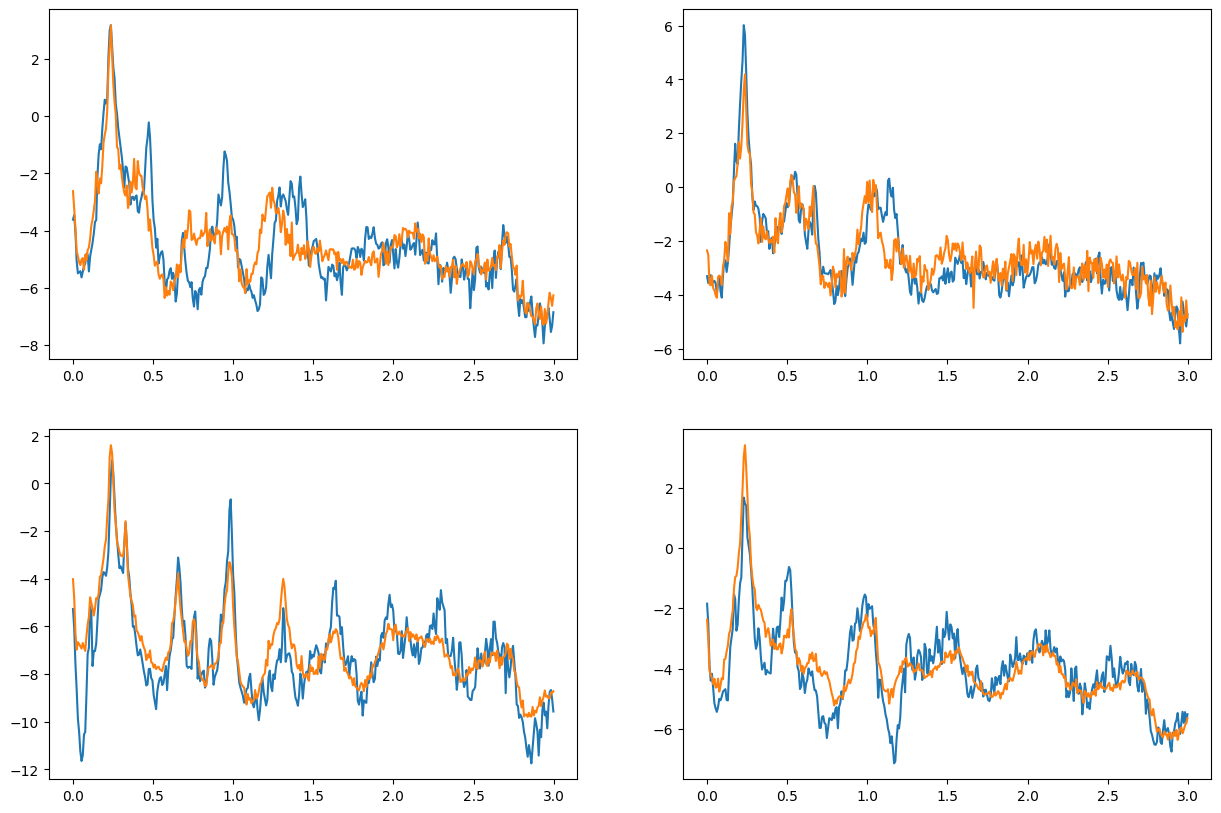

In [48]:
model_ae.to('cpu')
data = next(iter(data_loader.train_dataloader()))

data_rec = model_ae(data) 
data=data['Welch_X']
data_rec = data_rec[0]['Welch_X']
fig,ax  = plt.subplots(2,2,figsize=(15,10))
for i,(psd_in, psd_out) in enumerate(zip(data[0:4], data_rec[0:4])):
    ax[i//2, i%2].plot(freq_axis_masked, psd_in.cpu().numpy())
    ax[i//2, i%2].plot(freq_axis_masked, psd_out.cpu().detach().numpy())
plt.show()


In [49]:
from src.model.transformation import ToTensor
from src.model.prepared_queries import welch_all_scada_all
columns = ['Welch_X', 'Welch_Y', 'Welch_Z','RollingAverage_X','RollingAverage_Y','RollingAverage_Z','mean_windspeed','mean_power','mean_pitch','mean_rpm','caseID','turbine_name']
fleet_leaders = list(settings.norther.fleet_leader)
transform_func = 3*[nn.Sequential(FromBuffer(),CutPSD(frequency_axis, (0, 3)),LogTransform())]+3*[FromBuffer()]+4*[ToTensor()]+ 2*[nn.Identity()]
assert len(columns) == len(transform_func)
key_query  = f"""SELECT id FROM dem 
WHERE Turbine_name IN ('{"','".join(fleet_leaders[:5])}')
"""


data_loader_dem = dm.PSDDataModule(
    db_path=db_path,
    view_query=welch_all_scada_all, 
    view_table_name='dem',          # the view_table_name
    key_query=key_query,
    key_name='id',            # key_name required by the updated constructor
    columns=columns,
    transform_func=transform_func,
    batch_size=5000,
    cached=True,
    return_dict=True
)


In [50]:
data_loader_dem.setup() 

In [51]:
dfs = []
for b in data_loader_dem.all_dataloader():
    model_ae.eval()
    with torch.no_grad():
        enc = model_ae.model.encoder(b)[0]
    df_temp = pd.DataFrame({'mean_windspeed':b['mean_windspeed'].cpu().numpy(),
                            'mean_power':b['mean_power'].cpu().numpy(),
                            'mean_pitch':b['mean_pitch'].cpu().numpy(),
                            'mean_rpm':b['mean_rpm'].cpu().numpy(),
                            'caseID':b['caseID'],
                            'embedding':[e.cpu().numpy() for e in enc],
                            'turbine_name':b['turbine_name']})
    dfs.append(df_temp)
df = pd.concat(dfs)

/tmp/ipykernel_3131502/2608591003.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['caseID_encoded'] = label_encoder.fit_transform(df_plot['caseID'])
/tmp/ipykernel_3131502/2608591003.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['turbine_name_encoded'] = label_encoder.fit_transform(df_plot['turbine_name'])


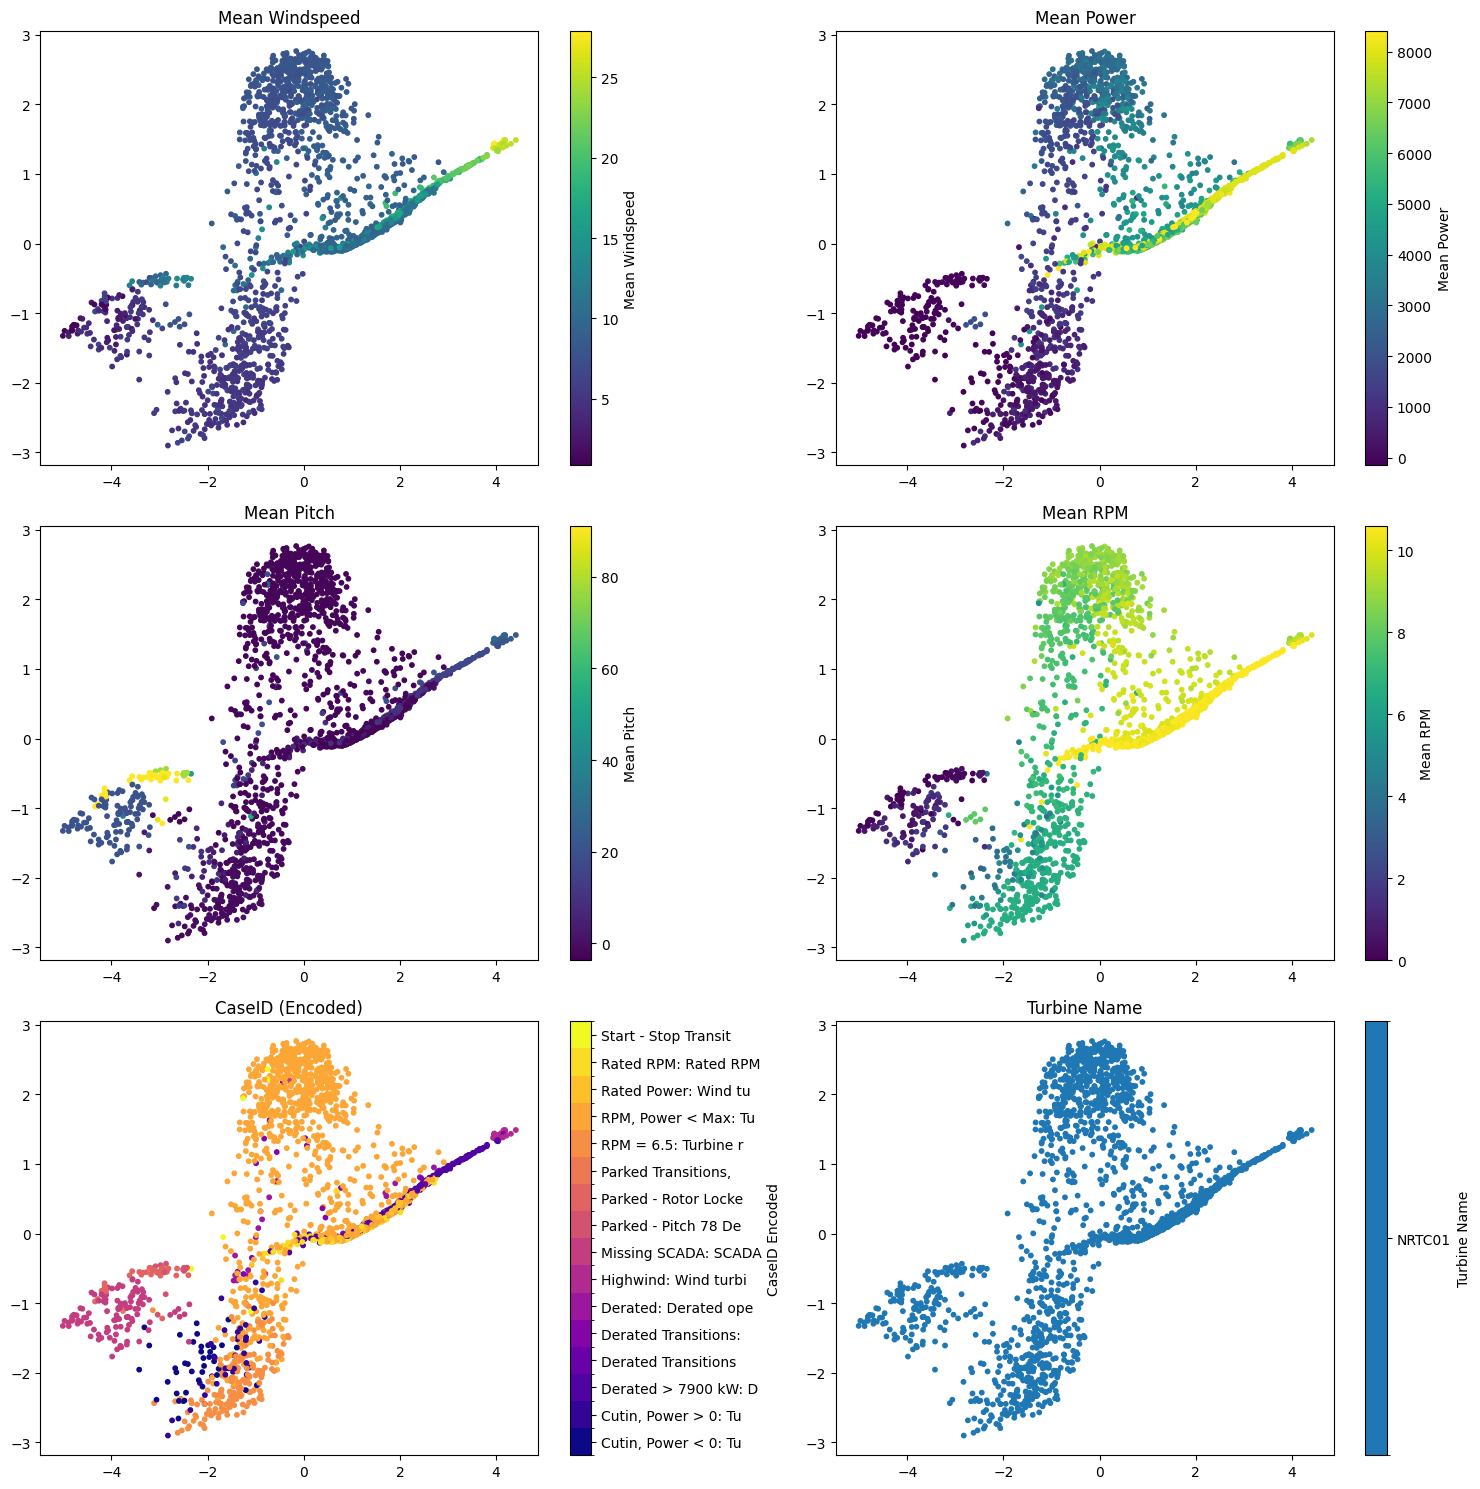

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [52]:
import pandas as pd
import numpy as np
from sklearn.manifold import TSNE
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, BoundaryNorm

df_plot = df[df['turbine_name'].isin(fleet_leaders[:1])]
# Encode caseID as numeric labels
label_encoder = LabelEncoder()
df_plot['caseID_encoded'] = label_encoder.fit_transform(df_plot['caseID']) 

# Retrieve the mapping of encoded labels to original caseID labels
encoded_labels = df_plot['caseID_encoded'].unique()
original_labels = label_encoder.inverse_transform(encoded_labels)
label_mapping = dict(zip(encoded_labels, original_labels))

# Combine all embeddings into a numpy array
embeddings = np.vstack(df_plot['embedding'].values)

# Apply t-SNE for dimensionality reduction
#reducer = umap.UMAP(n_components=2, random_state=42)
#embeddings_2d = reducer.fit_transform(embeddings)
embeddings_2d = embeddings
# Plot the t-SNE projection with color bars for each plot
# Plot the t-SNE projection with color bars for each plot
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 15))

# Mean Windspeed
sc1 = ax[0, 0].scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=df_plot['mean_windspeed'], cmap='viridis', s=10)
ax[0, 0].set_title('Mean Windspeed')
fig.colorbar(sc1, ax=ax[0, 0], label='Mean Windspeed')

# Mean Power
sc2 = ax[0, 1].scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=df_plot['mean_power'], cmap='viridis', s=10)
ax[0, 1].set_title('Mean Power')
fig.colorbar(sc2, ax=ax[0, 1], label='Mean Power')

# Mean Pitch
sc3 = ax[1, 0].scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=df_plot['mean_pitch'], cmap='viridis', s=10)
ax[1, 0].set_title('Mean Pitch')
fig.colorbar(sc3, ax=ax[1, 0], label='Mean Pitch')

# Mean RPM
sc4 = ax[1, 1].scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=df_plot['mean_rpm'], cmap='viridis', s=10)
ax[1, 1].set_title('Mean RPM')
fig.colorbar(sc4, ax=ax[1, 1], label='Mean RPM')

# CaseID Encoded (Discrete Colorbar)
cmap = plt.get_cmap('plasma', len(df_plot['caseID_encoded'].unique()))
norm = BoundaryNorm(np.arange(-0.5, len(df_plot['caseID_encoded'].unique())), cmap.N)
sc5 = ax[2, 0].scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=df_plot['caseID_encoded'], cmap=cmap, norm=norm, s=10)
ax[2, 0].set_title('CaseID (Encoded)')
cbar = fig.colorbar(sc5, ax=ax[2, 0], label='CaseID Encoded', ticks=np.arange(0, len(df_plot['caseID_encoded'].unique())))
cbar.ax.set_yticklabels([label_mapping[i][:20] for i in range(len(label_mapping))])

# Encode turbine_name as numeric labels
df_plot['turbine_name_encoded'] = label_encoder.fit_transform(df_plot['turbine_name'])

# Turbine Name (Discrete Colorbar) 
cmap = plt.get_cmap('tab20', len(df_plot['turbine_name_encoded'].unique()))
norm = BoundaryNorm(np.arange(-0.5, len(df_plot['turbine_name_encoded'].unique())), cmap.N)
sc6 = ax[2, 1].scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=df_plot['turbine_name_encoded'], cmap=cmap, norm=norm, s=10)
ax[2, 1].set_title('Turbine Name')
cbar = fig.colorbar(sc6, ax=ax[2, 1], label='Turbine Name', ticks=np.arange(0, len(df_plot['turbine_name_encoded'].unique())))
cbar.ax.set_yticklabels(label_encoder.inverse_transform(np.arange(0, len(df_plot['turbine_name_encoded'].unique()))))

# Adjust layout and show plot
plt.tight_layout()
plt.show()

# Adjust layout and show plot
plt.tight_layout()
plt.show()
ax[2, 1].axis('off')

# Adjust layout and show plot
plt.tight_layout()
plt.show()


In [127]:
from src.model.transformation import ToTensor
from src.model.prepared_queries import welch_all_scada_all
columns = ['Welch_X', 'Welch_Y', 'Welch_Z','RollingAverage_X','RollingAverage_Y','RollingAverage_Z','DEM']
fleet_leaders = list(settings.norther.fleet_leader)
transform_func = 3*[nn.Sequential(FromBuffer(),CutPSD(frequency_axis, (0, 3)),LogTransform())]+3*[FromBuffer()]+[ToTensor()]
assert len(columns) == len(transform_func)
key_query  = f"""SELECT id FROM dem 
WHERE timestamp BETWEEN '{settings.norther.training_start}' AND '2024-01-01'
AND Turbine_name IN ('{"','".join(fleet_leaders[:1])}')
"""


data_loader_dem = dm.PSDDataModule(
    db_path=db_path,
    view_query=welch_all_scada_all, 
    view_table_name='dem',          # the view_table_name
    key_query=key_query,
    key_name='id',            # key_name required by the updated constructor
    columns=columns,
    transform_func=transform_func,
    batch_size=32,
    cached=True,
    return_dict=True
)


In [21]:
data_loader_dem.setup()

In [22]:
len(data_loader_dem.train_dataloader().dataset)

776

torch.Size([149])


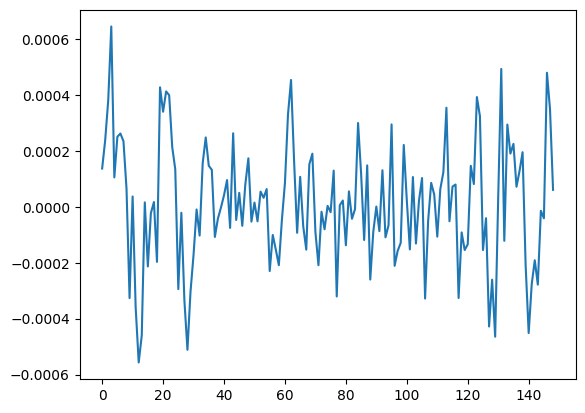

torch.Size([149])


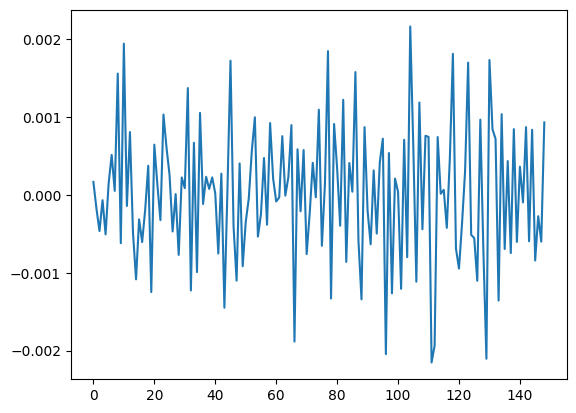

torch.Size([149])


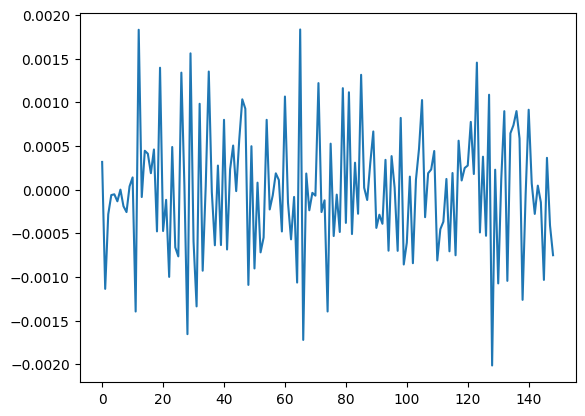

torch.Size([149])


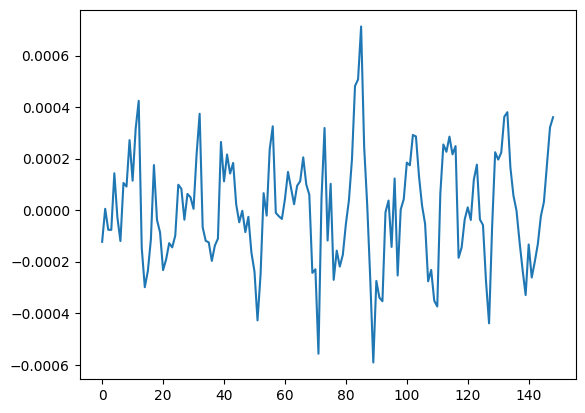

torch.Size([149])


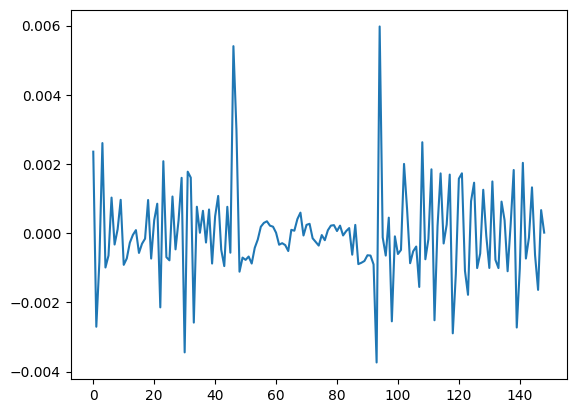

torch.Size([149])


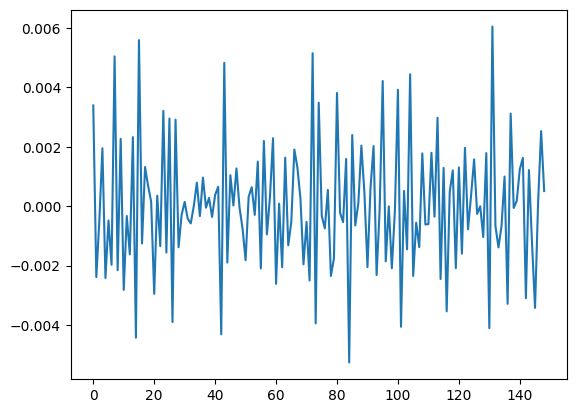

torch.Size([149])


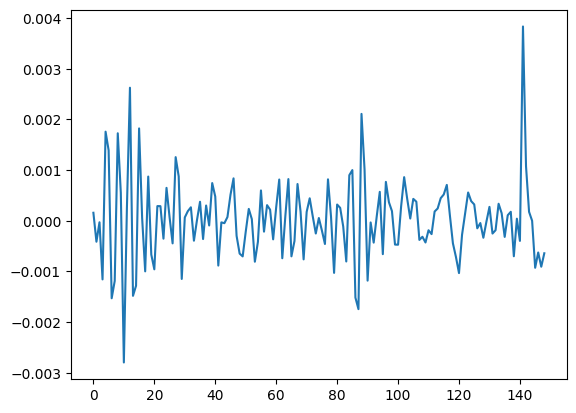

torch.Size([149])


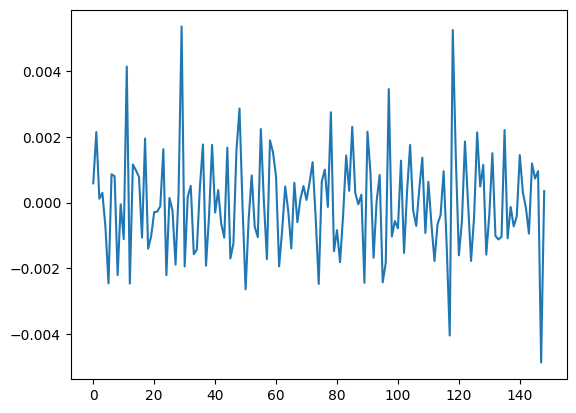

torch.Size([149])


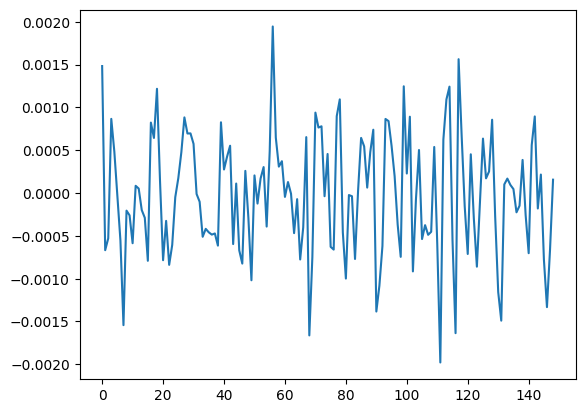

torch.Size([149])


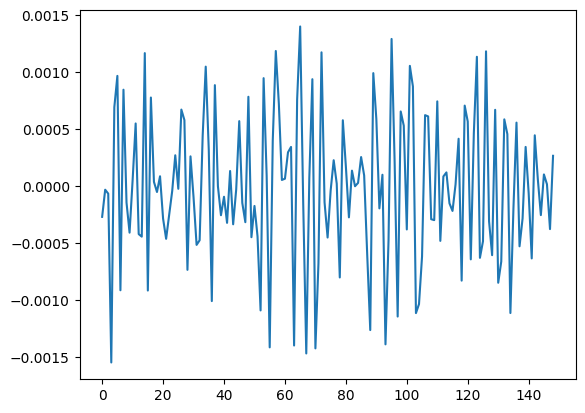

torch.Size([149])


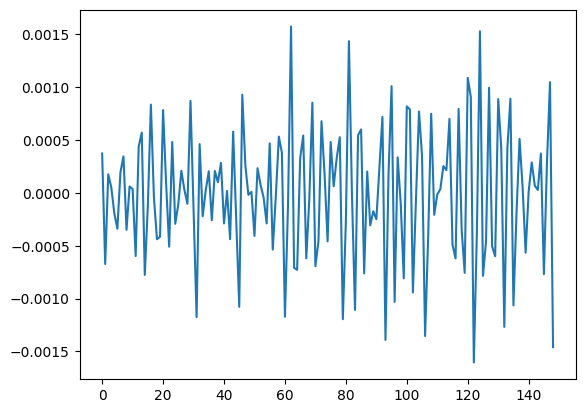

torch.Size([149])


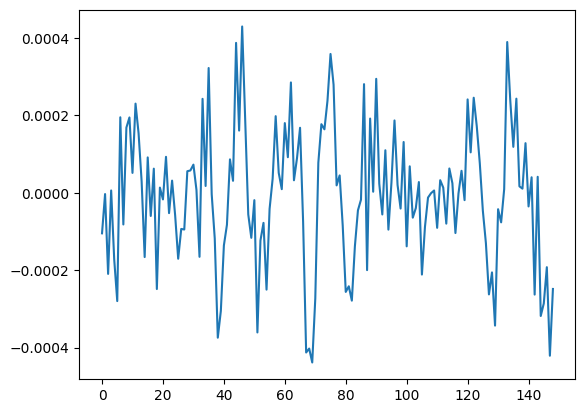

torch.Size([149])


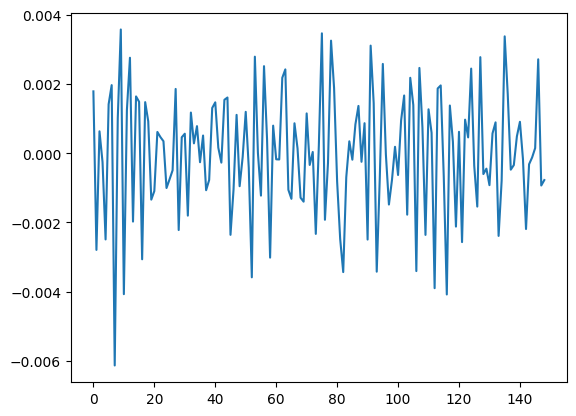

torch.Size([149])


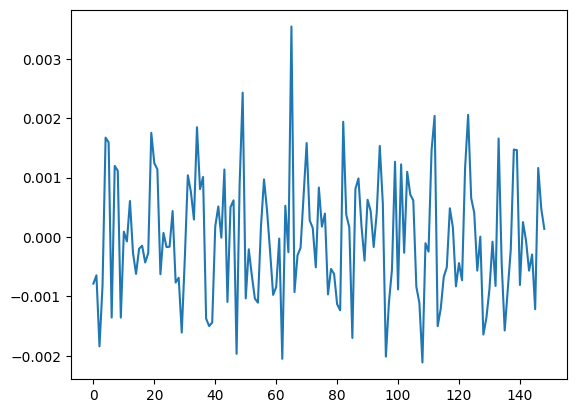

torch.Size([149])


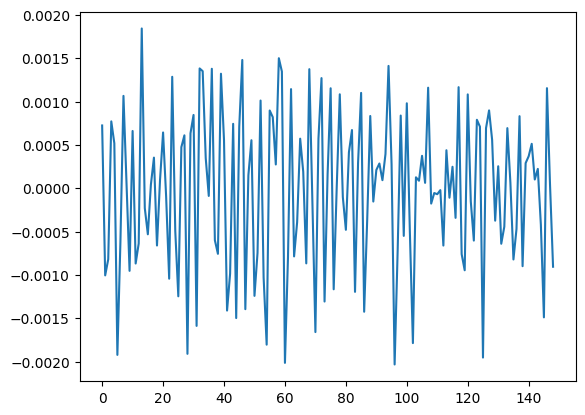

torch.Size([149])


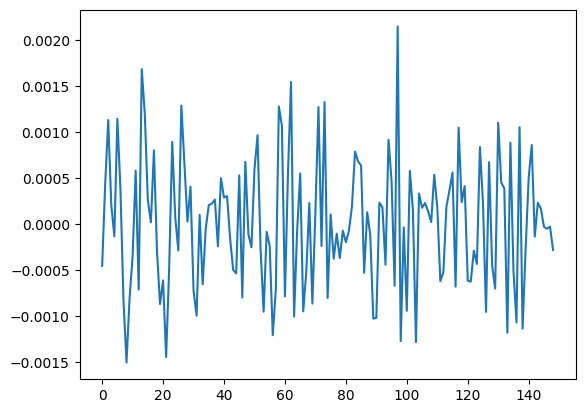

torch.Size([149])


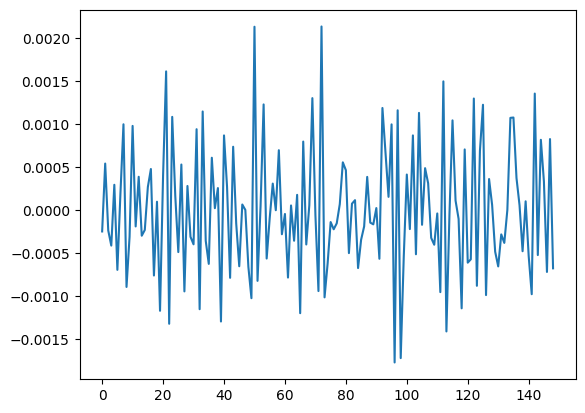

torch.Size([149])


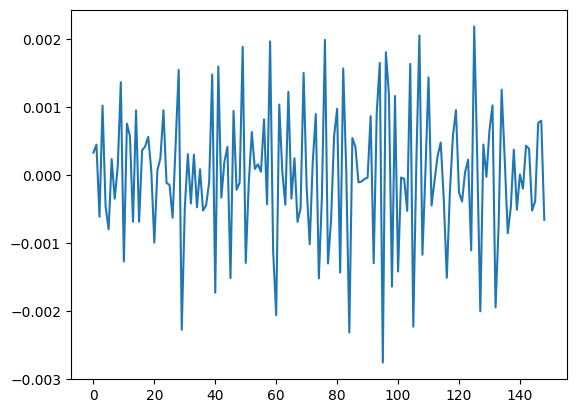

torch.Size([149])


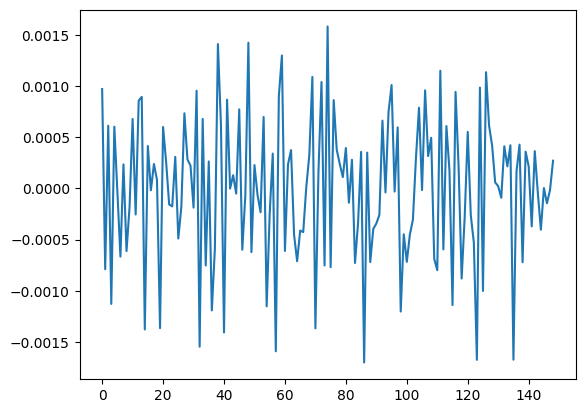

torch.Size([149])


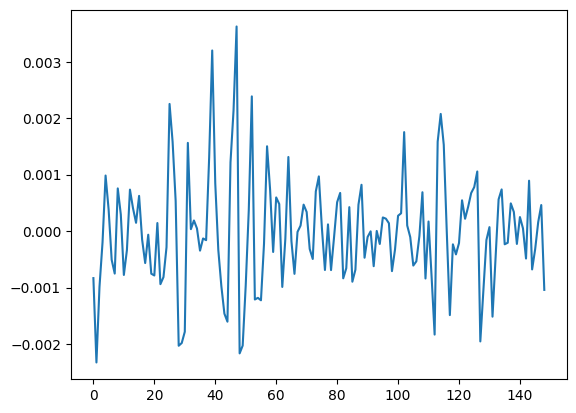

torch.Size([149])


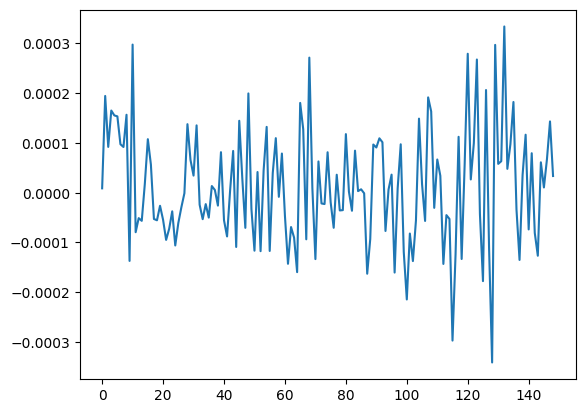

torch.Size([149])


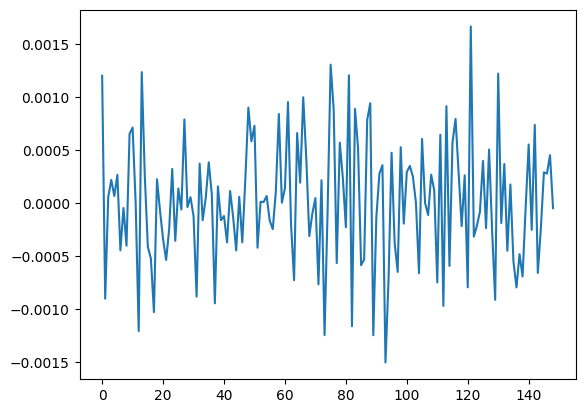

torch.Size([149])


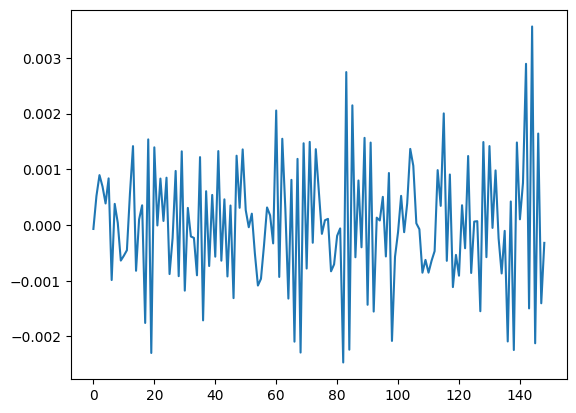

torch.Size([149])


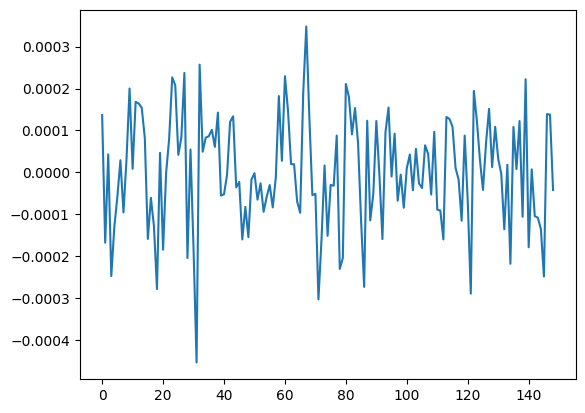

torch.Size([149])


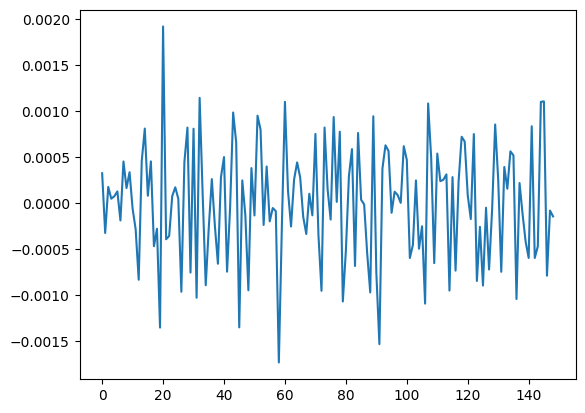

In [25]:
for b in data_loader_dem.train_dataloader():
    ts = b['RollingAverage_Y'][0]
    print(ts.shape)
    plt.plot(ts.cpu().numpy().T)
    plt.show()
    plt.close()

In [76]:
import torch
from torch import nn, optim
import pytorch_lightning as pl
import torch
from torch import nn


from src.model.backbone import MultiModalRegressor, SimpleMLP
class AutoEncoderRegressor(pl.LightningModule):
    def __init__(self, encoder_path: nn.Module,  lr: float = 1e-3, lr_encoder: float = 1e-4, freeze_encoder=True):
        super(AutoEncoderRegressor, self).__init__()
        self.encoder_path = encoder_path
        self.ae = TrainingAutoEncoderConv.load_from_checkpoint(encoder_path)
        self.encoder = self.ae.model.encoder
        self.regressor = MultiModalRegressor(input_dims={'RollingAverage_X':149,
                                                         'RollingAverage_Y':149,
                                                         'RollingAverage_Z':149,
                                                         'encoded':32},
                                             normalization_values = statistics,
                                             separated_layer= [128,64,16],
                                             shared_layer=[128,8],
                                             activation_str='leakyrelu',
                                             not_encoder =['encoded'])

        #self.regressor = SimpleMLP(input_dim = 32, hidden_dim=[16,8])
        
        
        self.lr = lr
        self.lr_encoder = lr_encoder
        self.freeze_encoder = freeze_encoder
        self.loss_fn = nn.MSELoss()
        # Configure parameter training
        for param in self.encoder.parameters():
            param.requires_grad = not freeze_encoder
        for param in self.regressor.parameters():
            param.requires_grad = True

        self.save_hyperparameters(ignore=['encoder', 'regressor'])

    def forward(self, x):
        """
        Forward pass: encode inputs and predict regression target.
        """
        if self.freeze_encoder:
            with torch.no_grad():
                encoded = self.encoder(x)
        else:
            encoded = self.encoder(x)
        # Add the encoded output to the input dictionary
        x.update({'encoded': encoded})
        # Pass the updated dictionary to the regressor
        dem = self.regressor(x)
        x.update({'pred_DEM': dem})
        return x


    def _common_step(self, batch, stage: str):
        """
        Common logic for training and validation steps.
        Args:
            batch: Input batch containing features and labels.
            stage: The stage of the step (e.g., 'train', 'val').
        Returns:
            Loss value for the step.
        """
        y_pred = self(batch)
        y = batch['DEM']
        y_pred = y_pred['pred_DEM'].squeeze()
        loss = self.loss_fn(y_pred, y)
        self.log(f'{stage}_loss', loss, on_step=False, on_epoch=True, prog_bar=True)
        return loss

    def training_step(self, batch, batch_idx):
        return self._common_step(batch, stage='train')

    def validation_step(self, batch, batch_idx):
        return self._common_step(batch, stage='val')

    def configure_optimizers(self):
        optimizer = optim.Adam(self.regressor.parameters(), lr=self.lr)
        if self.freeze_encoder:
            optimizer.add_param_group({'params': self.encoder.parameters(), 'lr': self.lr_encoder})
        return optimizer


In [53]:
from src.model.backbone import SimpleMLP
encoder = model_ae.model.encoder
encoder.eval()
model_all = AutoEncoderRegressor(best_ae_path, lr=1e-4,freeze_encoder=True,lr_encoder=0)
mlflow_logger = MLFlowLogger(
    experiment_name="AE-allturbine-Regressor-c01-turbine",
    save_dir=settings.path.mlflow[1:]
)

checkpoint_callback = ModelCheckpoint(
    monitor='val_loss', 
    save_top_k=1, 
    filename='AE-Regressor-{epoch:02d}-{val_loss:.2f}'
)
trainer = pl.Trainer(max_epochs=100, logger=mlflow_logger, callbacks=[checkpoint_callback])

trainer.fit(model_all, data_loader_dem)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                    | Params | Mode 
--------------------------------------------------------------
0 | ae        | TrainingAutoEncoderConv | 1.8 M  | train
1 | encoder   | MultiEncoder            | 868 K  | train
2 | regressor | MultiModalRegressor     | 98.4 K | train
3 | loss_fn   | AsymmetricLoss          | 0      | train
--------------------------------------------------------------
981 K     Trainable params
868 K     Non-trainable params
1.8 M     Total params
7.398     Total estimated model params size (MB)
113       Modules in train mode
0         Modules in eval mode


Already set


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/owilab/Documents/YacineB/Code/damage_prediction_AE/.venv/lib/python3.10/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (25) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [54]:
best_model_path = Path(checkpoint_callback.best_model_path)
model_all = AutoEncoderRegressor.load_from_checkpoint(best_model_path)

In [80]:
from src.model.transformation import ToTensor
from src.model.prepared_queries import welch_all_scada_all
columns = ["timestamp","turbine_name","Welch_X","Welch_Y","Welch_Z",'RollingAverage_X','RollingAverage_Y','RollingAverage_Z',"DEM","mean_windspeed","mean_power","mean_rpm"] 
transform_func = [nn.Identity(),nn.Identity()]+\
    3*[nn.Sequential(FromBuffer(),CutPSD(frequency_axis, (0, 3)),LogTransform())]+ 3*[FromBuffer()]+\
    4*[ToTensor()]
key_query  = f"""SELECT id FROM dem WHERE turbine_name in {tuple(fleet_leaders)[0]} AND timestamp > '2024-01-01'"""

data_loader_dem_all = dm.PSDDataModule(
    db_path=db_path,
    view_query=welch_all_scada_all, 
    view_table_name='dem',          # the view_table_name
    key_query=key_query,
    key_name='id',            # key_name required by the updated constructor
    columns=columns,
    transform_func=transform_func,
    batch_size=5000,
    cached=False,
    return_dict=True
)



In [79]:
data_loader_dem_all.setup()

OperationalError: near "WHERE": syntax error

In [55]:
from src.model.transformation import ToTensor
from src.model.prepared_queries import welch_all_scada_all
columns = ["timestamp","turbine_name","Welch_X","Welch_Y","Welch_Z",'RollingAverage_X','RollingAverage_Y','RollingAverage_Z',"DEM"]
fleet_leaders = list(settings.norther.fleet_leader)
transform_func = [nn.Identity(),nn.Identity()]+\
    3*[nn.Sequential(FromBuffer(),CutPSD(frequency_axis, (0, 3)),LogTransform())]+ 3*[FromBuffer()]+\
    [ToTensor()]
assert len(columns) == len(transform_func)
key_query  = f"""SELECT id FROM dem WHERE turbine_name in {tuple(fleet_leaders)} """


data_loader_dem_all = dm.PSDDataModule(
    db_path=db_path,
    view_query=welch_all_scada_all, 
    view_table_name='dem',          # the view_table_name
    key_query=key_query,
    key_name='id',            # key_name required by the updated constructor
    columns=columns,
    transform_func=transform_func,
    batch_size=5000,
    cached=False,
    return_dict=True
)

In [56]:
data_loader_dem_all.setup()

In [57]:
import pandas as pd
dfs = []

# Iterate over batches from the dataloader
for batch in data_loader_dem_all.all_dataloader():
    batch = {k: v.to(model_all.device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
    # Extract relevant keys from the batch
    timestamps = batch['timestamp']
    turbine_names = batch['turbine_name']
    dem = batch['DEM']

    # Forward pass: model_all expects the batch dictionary
    with torch.no_grad():
        data = model_all(batch)  # batch includes all input features
    pred_dem = data['pred_DEM']
    # Create a DataFrame for the current batch
    
    df_temp = pd.DataFrame({
        'timestamp': np.array(timestamps),
        'turbine_name': np.array(turbine_names),
        'dem': np.array(dem.cpu()),
        'pred_DEM': pred_dem.squeeze().cpu().numpy(),
    })
    dfs.append(df_temp)

# Concatenate all batch results
data = pd.concat(dfs, ignore_index=True)


/tmp/ipykernel_1433848/3130173591.py:21: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  'dem': np.array(dem.cpu()),


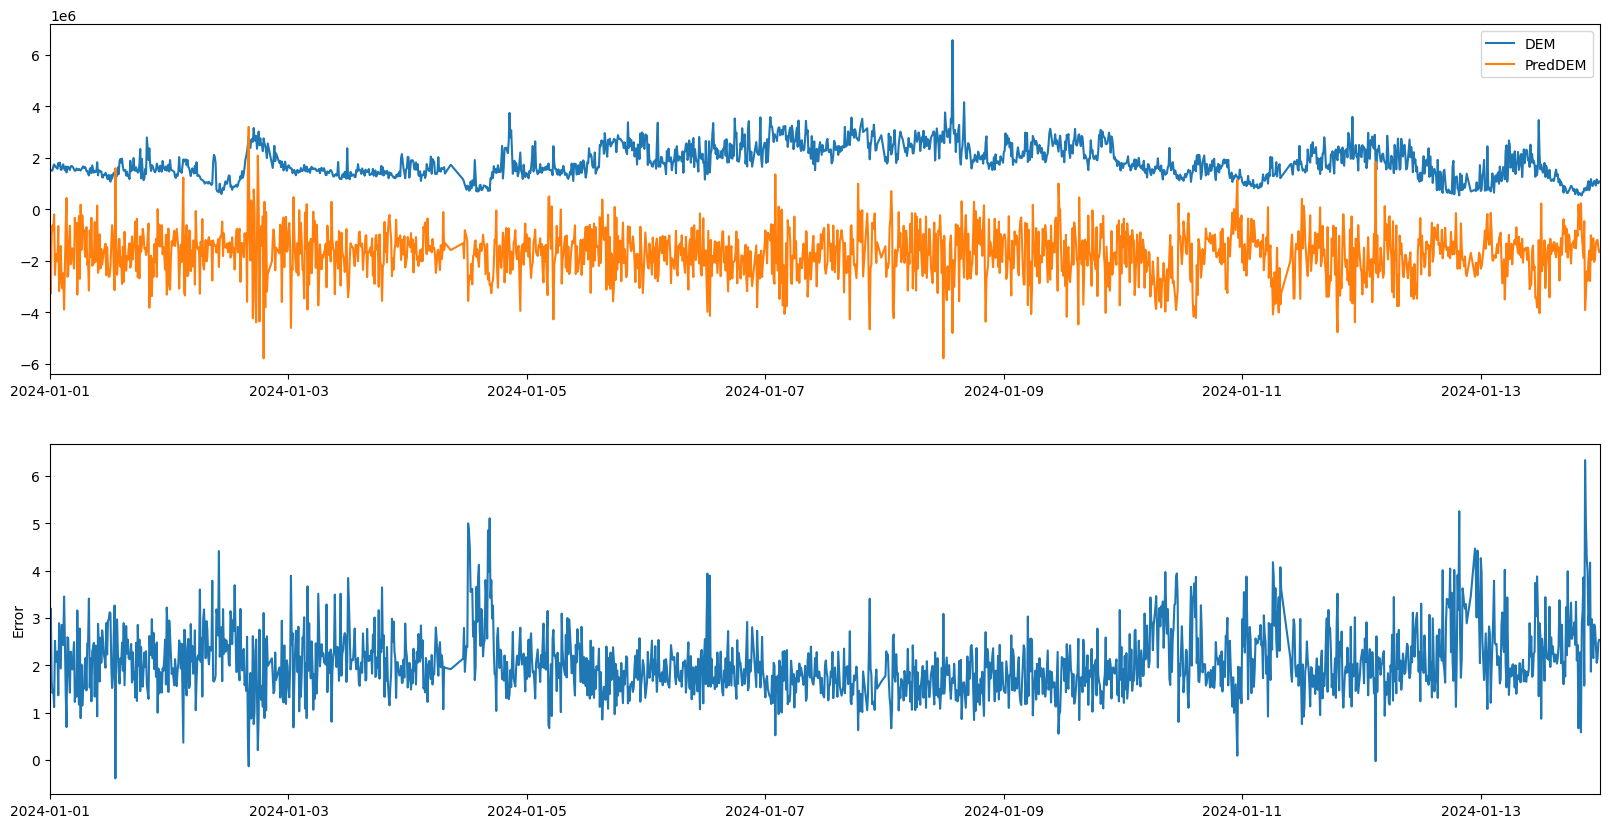

In [58]:
data = pd.concat(dfs).query("turbine_name == 'NRTC03' and '2024-01-01' <= timestamp <= '2024-01-14'")
data['timestamp'] = pd.to_datetime(data['timestamp'])
fig , ax = plt.subplots(2,1, figsize=(20,10))
ax[0].plot(data['timestamp'], data['dem'], label='DEM')
ax[0].plot(data['timestamp'], data['pred_DEM'], label='PredDEM')
ax[0].set_xlim(pd.to_datetime('2024-01-01'), pd.to_datetime('2024-01-14'))
ax[0].legend()
err  = (data['dem'] - data['pred_DEM']) / data['dem']
ax[1].plot(data['timestamp'], err, label='Error')
ax[1].set_xlim(pd.to_datetime('2024-01-01'), pd.to_datetime('2024-01-14'))
ax[1].set_ylabel('Error')
plt.show()


In [189]:
from src.evaluation.metric import r2_score, relative_err

In [192]:
pd.concat(dfs).groupby('turbine_name').apply(lambda x: r2_score(x['dem'], x['pred_DEM']))

/tmp/ipykernel_692092/2207033503.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pd.concat(dfs).groupby('turbine_name').apply(lambda x: r2_score(x['dem'], x['pred_DEM']))


turbine_name
NRTC01    0.424977
NRTC03    0.395995
NRTF03    0.358441
NRTH01   -0.461933
NRTJ03    0.212387
dtype: float32

In [193]:
pd.concat(dfs).groupby('turbine_name').apply(lambda x: relative_err(x['dem'], x['pred_DEM']))

/tmp/ipykernel_692092/2453565944.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pd.concat(dfs).groupby('turbine_name').apply(lambda x: relative_err(x['dem'], x['pred_DEM']))


turbine_name
NRTC01    0.270408
NRTC03    0.273663
NRTF03    0.291501
NRTH01    0.397669
NRTJ03    0.311172
dtype: float32